# Thermal Testing Data Processing Tool

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
tool_start = datetime.datetime.now()

# Control Panel
Define variables for test (Project title, temperature limits, duration, rounding requirements)

In [3]:
#Set file name here.  File must be in data folder in same directory as tool.
file = 'data/MockTest_Example.xlsm'
#Set project title to appear in graphs.
project_title = 'MockTest Example'

#Set temperature limits
upper_limit = 30
lower_limit = 0

#Set duration requirements
duration = 96

#Set rounding requirements
round = 1

#set isc identifier digits (ISC1-ISC9; digit=1: ISC10-ISC99; digit=2)
digit = 1

#Consider air probes in analysis?
air_probes=False

In [4]:
if not os.path.exists(f'figures/{project_title}'):
                      os.mkdir(f'figures/{project_title}')
                      
if not os.path.exists(f'tables/{project_title}'):
                      os.mkdir(f'tables/{project_title}')  

writer = pd.ExcelWriter(f'tables/{project_title}/{project_title}_Analysis.xlsx', engine='xlsxwriter')

## Read file

In [5]:
#Read in raw data file from test output .xlsm
df_raw=pd.read_excel(file)

#Determine which row the test data begins
for row in range(df_raw.shape[0]):
    for col in range(df_raw.shape[1]):
        if df_raw.iat[row, col] == 'Date Time':
            row_start = row
        break

#Read in raw data file begining with test data
df_data = pd.read_excel(file, skiprows=row_start+1)

drop_col = df_data.columns[1]
drop_col

if drop_col == 'Watlow':
    df_data = df_data.drop(columns=[drop_col, "Over Limit"])
else:
    df_data = df_data.drop(columns=drop_col)
    df_data = df_data.loc[:, :'Over Limit']
    df_data = df_data.drop(columns="Over Limit")

## Data Cleanup

In [6]:
#Set index to Date Time Column
df_data_index = df_data.set_index('Date Time')
df_chart = df_data.set_index('Date Time')

#Get thermocouple names used in testing
tc_names = list(df_chart)

#Sort thermocouples by type (Ambient, Air, or Product)
ambs = [tc_name for tc_name in tc_names if "AMB" in tc_name]
airs = [tc_name for tc_name in tc_names if "AIR" in tc_name]
prds = [tc_name for tc_name in tc_names if "PRD" in tc_name]

#Get number of unique shipper IDs (ISC1, ISC2, etc)
groups = list(df_chart)

#Create list of shippers (ISC1, ISC2, etc)
num_index = 100
shippers = []
for item in groups:
    if "AMB" not in item:
        end = 7 + digit
        shippers.append(item[4:end])
        num = int(item[7:end])
        if num <= num_index:
            num_index = num
            
#Determine number of shippers tested by shipper ID
max_shippers = len(set(shippers))

## Calculate Elapsed Time

In [7]:
#Convert values to date and time values for calculations
datetime = pd.to_datetime(df_data['Date Time'], dayfirst=True)
datetime = pd.to_timedelta(datetime)
df_formatted = df_data
df_formatted['Date Time'] = pd.to_datetime(df_formatted['Date Time'])

#Store start time of test as variable
start_time = df_formatted['Date Time'].iloc[0]

#Calcuate elapsed time at each data point and store into new column
df_formatted['Elapsed Time'] = df_formatted['Date Time'] - start_time

#Convert elapsed time to hours
df_formatted['Elapsed Time (Hours)'] = ((df_formatted["Elapsed Time"].dt.total_seconds())/3600).round(round)

#Round to decimal places as indicated in control panel
elapsed_time = df_formatted['Elapsed Time (Hours)'].round(round)

#Set new index to be elapsed time in hours
df_chart = df_formatted.set_index('Elapsed Time (Hours)')
df_chart = df_chart.drop(columns=['Elapsed Time', 'Date Time'])

In [8]:
end_test = df_chart.index[-1]

## Filter data by performance period

In [9]:
#Create dataframe of values only within the required performance period for calculations
df_dur = df_chart
df_dur = df_dur.reset_index()
df_dur = df_dur[df_dur['Elapsed Time (Hours)'] < (duration+.1)]
df_dur = df_dur.set_index('Elapsed Time (Hours)')
df_dur = df_dur.drop(columns=ambs)
if air_probes == False:
    df_dur = df_dur.drop(columns=airs, axis=1)

In [10]:
df_chart.to_excel(writer, sheet_name='AllData')

# Graphs - All
Includes all test data.

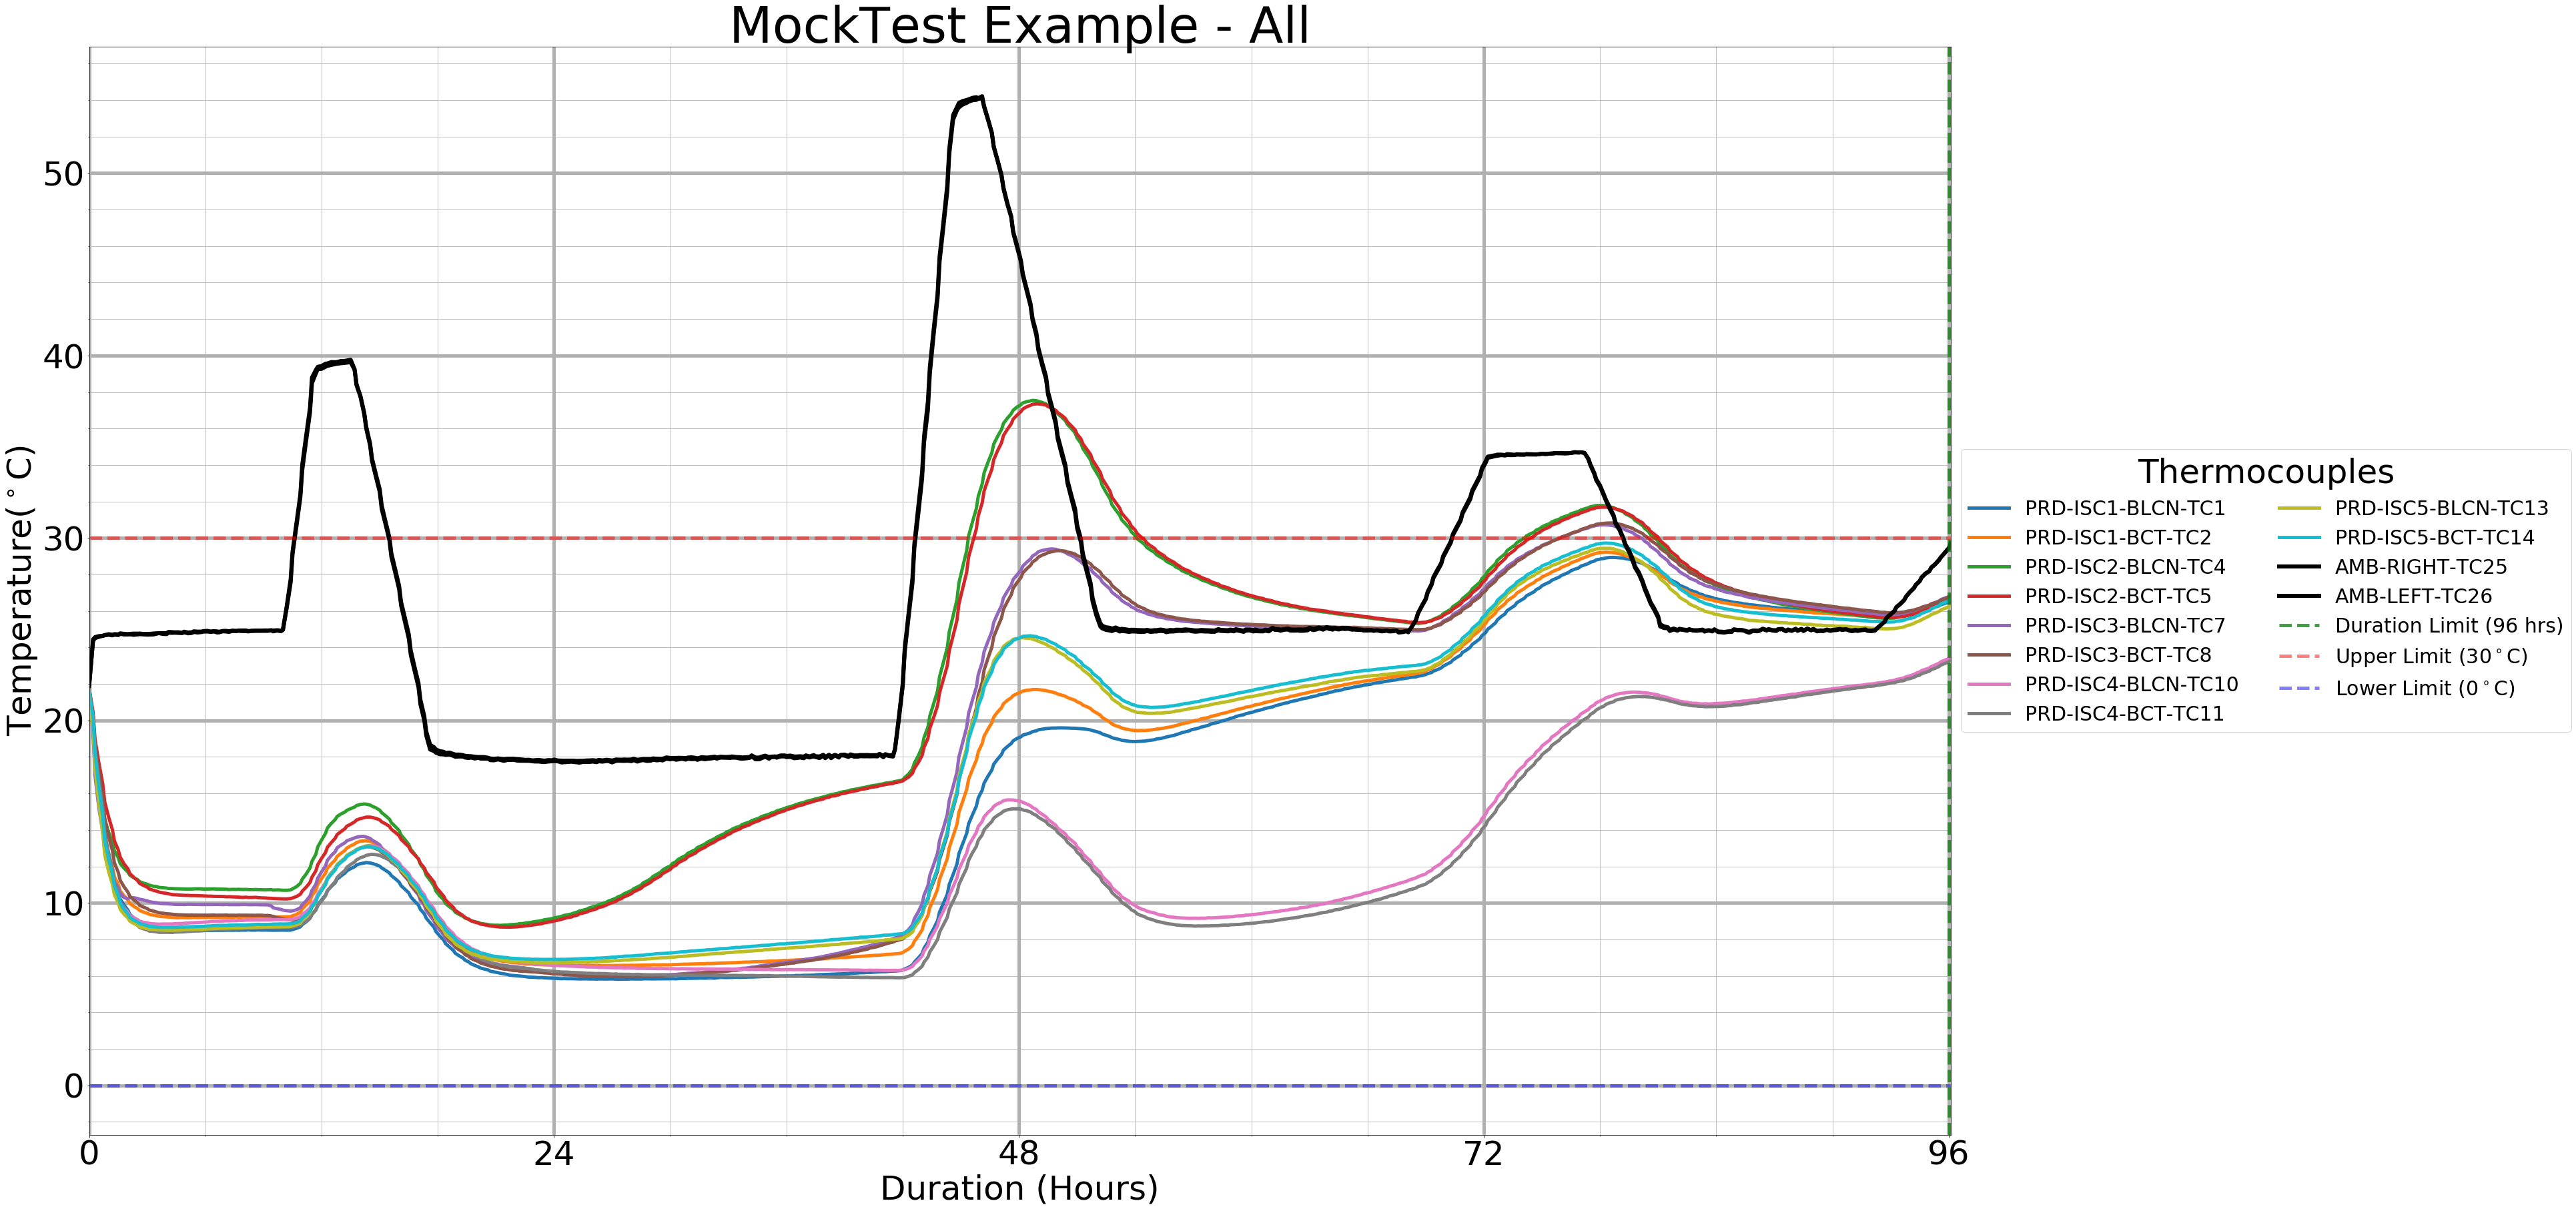

In [11]:
figsize=(50,30)
fig1, ax1 = plt.subplots(figsize=figsize)
fontsize=50
linewidth=5

major_ticks = np.arange(0, end_test, 24)
minor_ticks = np.arange(0, end_test, 12)

#Plot all probes
for i in df_chart:
    if i in ambs:
        ax1.plot(df_chart[i], color='black', lw=1.2*linewidth)
    if i in prds:
        ax1.plot(df_chart[i], lw=linewidth)
    if air_probes==True:
        if i in airs:
            ax1.plot(df_chart[i], alpha=.5, lw=linewidth)
    ax1.set_xticks(major_ticks, minor=False)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.grid(True, which='both')
    plt.minorticks_on()


#Format graph title, axis, and grid
plt.title(f'{project_title} - All', fontsize=fontsize*1.5)
plt.xlabel('Duration (Hours)', fontsize=fontsize)
plt.ylabel('Temperature($^\circ$C)', fontsize=fontsize)
plt.xlim(0,end_test)

#Add duration line (vertical), add upper and lower temp limits
plt.axvline(x=duration, alpha=.75, linestyle='--', color='green', label=f"Duration Limit ({duration} hrs)", linewidth=linewidth)
plt.axhline(y=upper_limit, alpha=.5, linestyle='--', color='red', label=f'Upper Limit ({upper_limit}$^\circ$C)', linewidth=linewidth)
plt.axhline(y=lower_limit, alpha=.5, linestyle='--', color='blue', label=f'Lower Limit ({lower_limit}$^\circ$C)', linewidth=linewidth)

#Add legend
leg = plt.legend(loc='center left', bbox_to_anchor=(1, .5), title='Thermocouples', ncol=2, fontsize=30)
leg.set_title('Thermocouples',prop={'size':fontsize})

plt.tick_params(axis='both', which='major', labelsize=50)
plt.grid(linewidth=linewidth)


#Save figure
plt.savefig(f'figures/{project_title}/{project_title}-All.png', bbox_inches='tight')
plt.show()

# Graphs - Individual
Includes all test data.

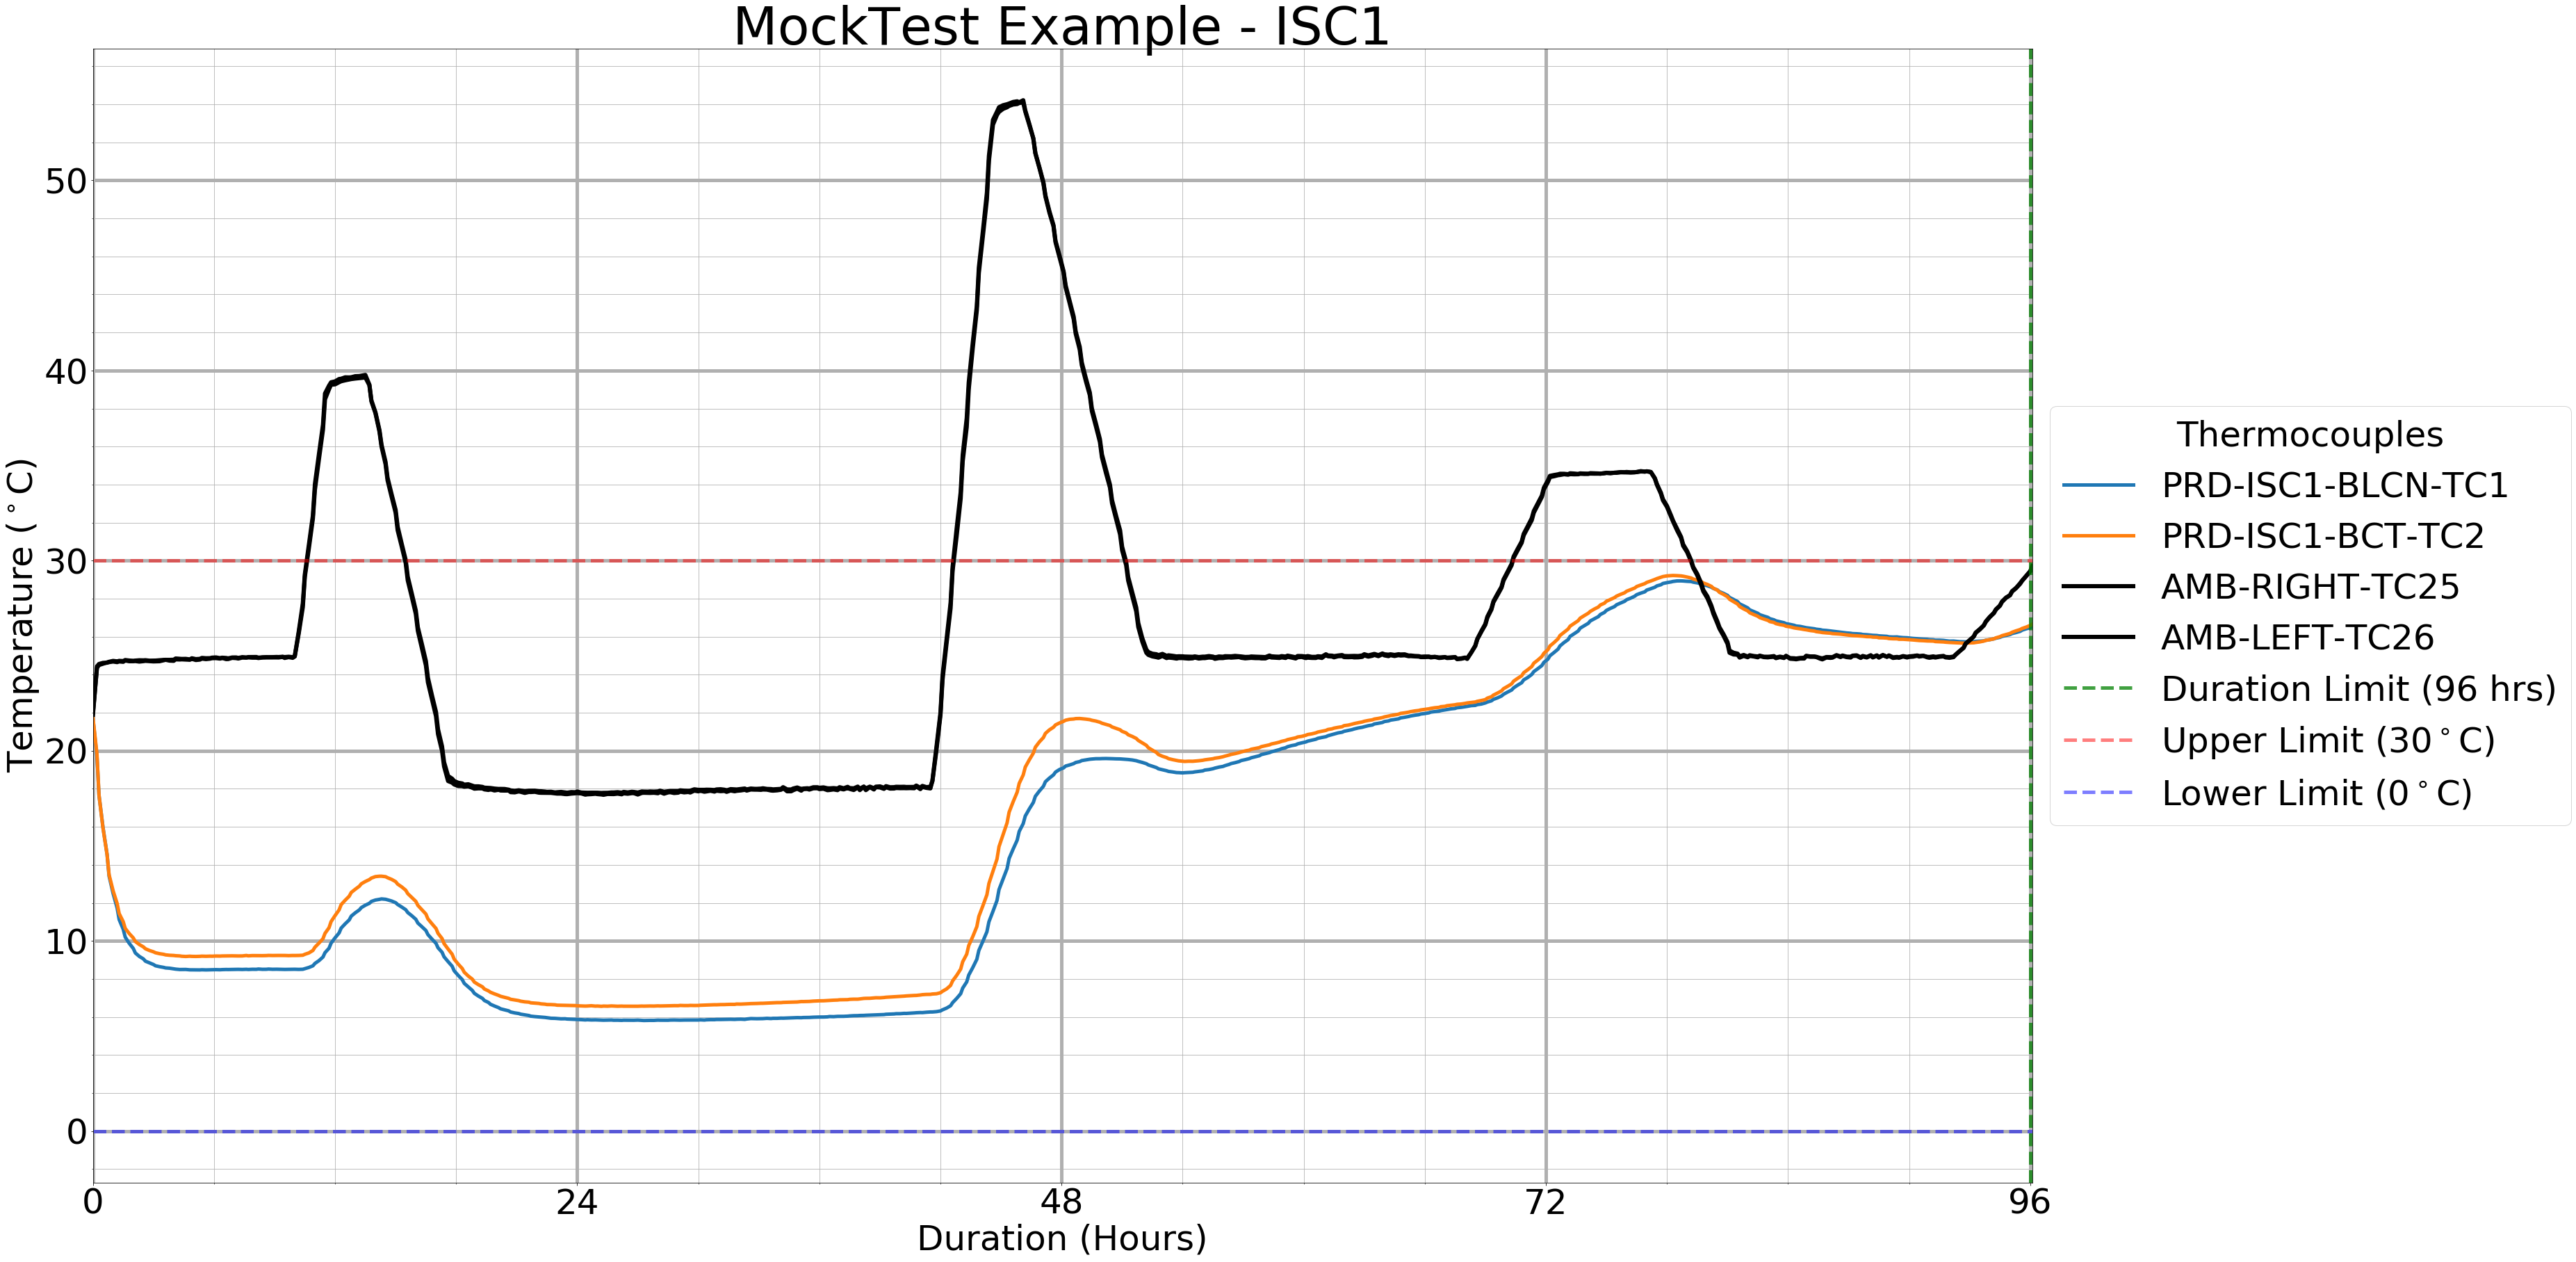

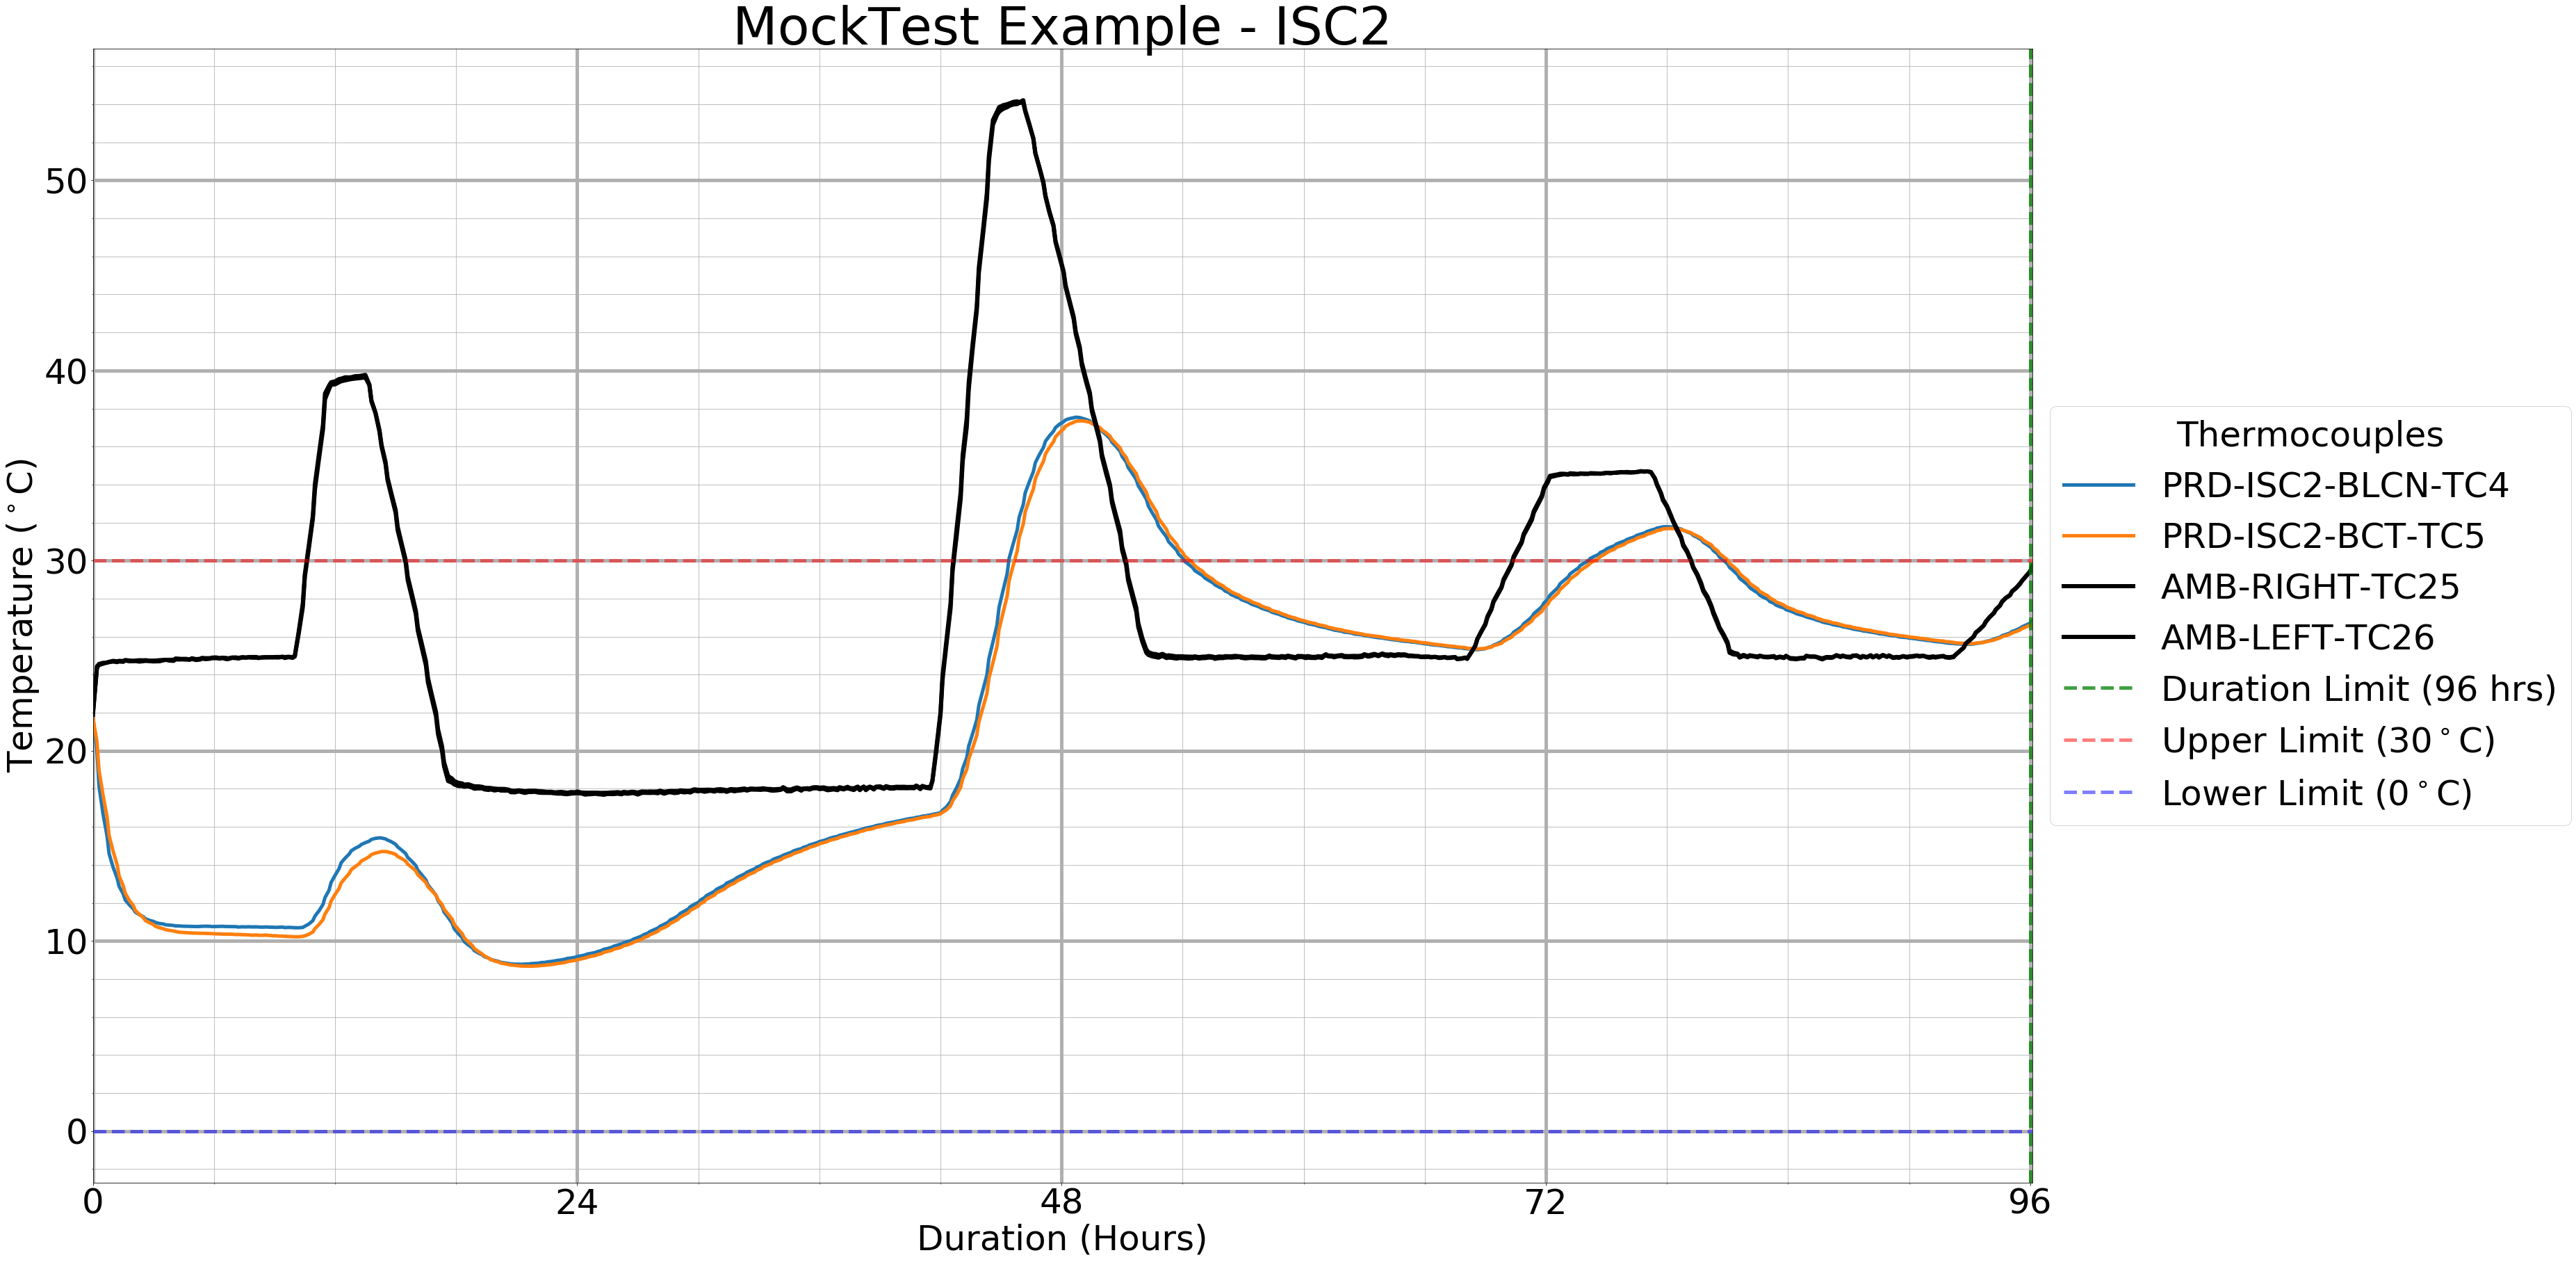

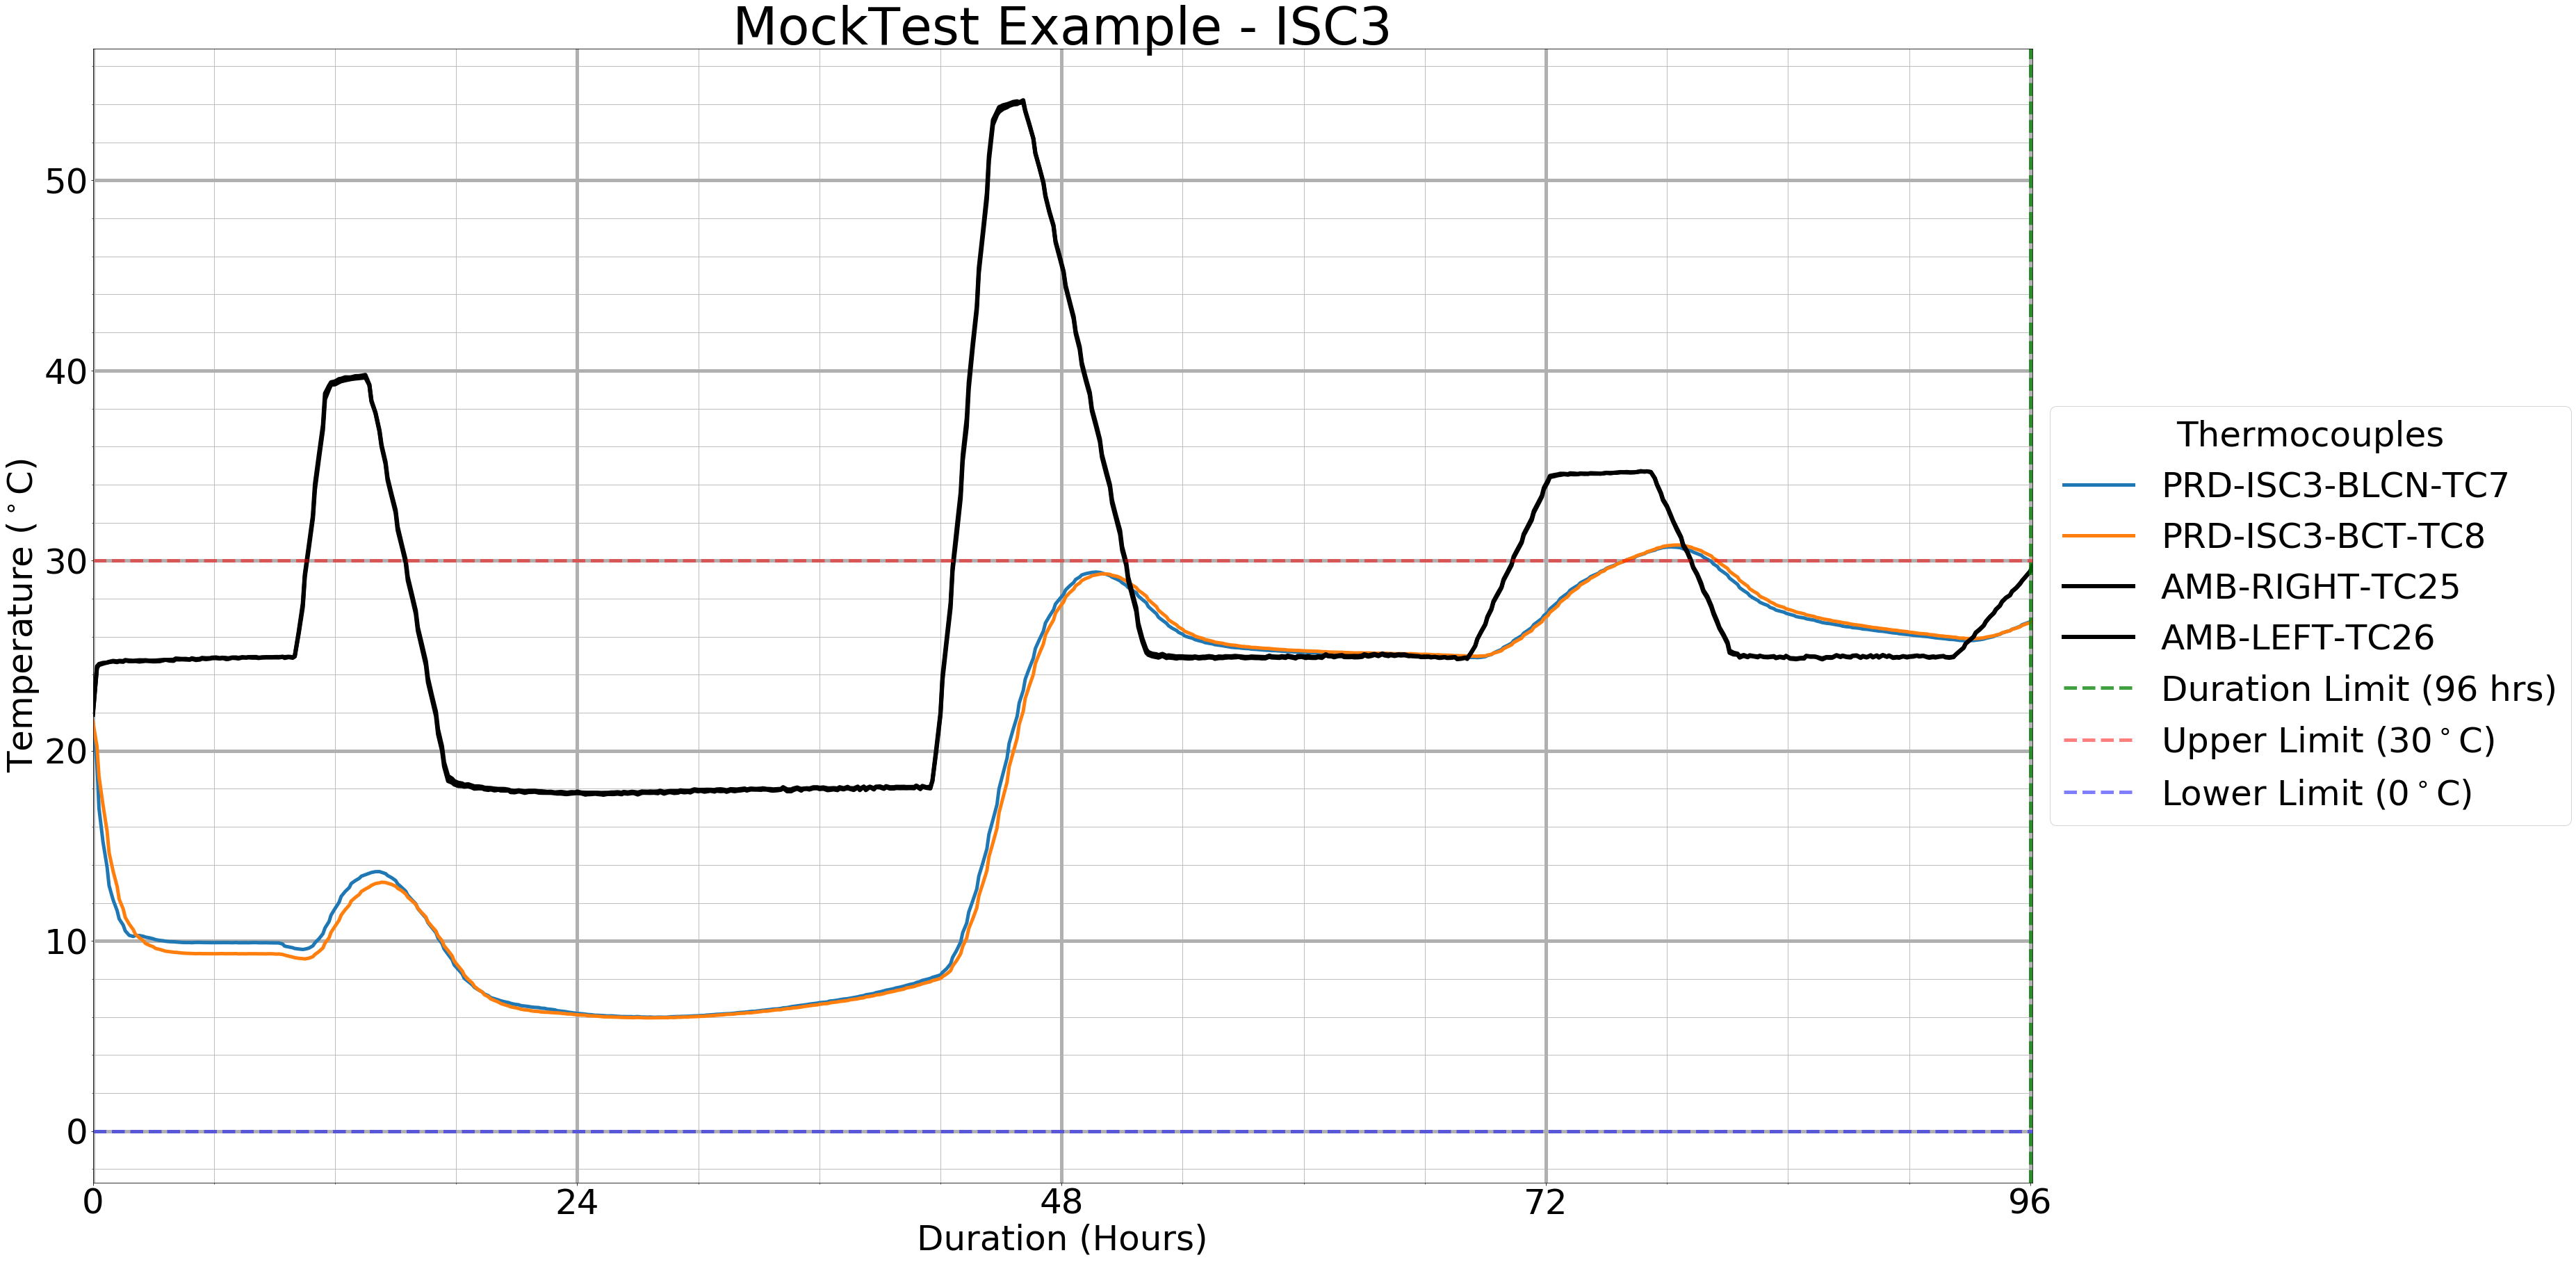

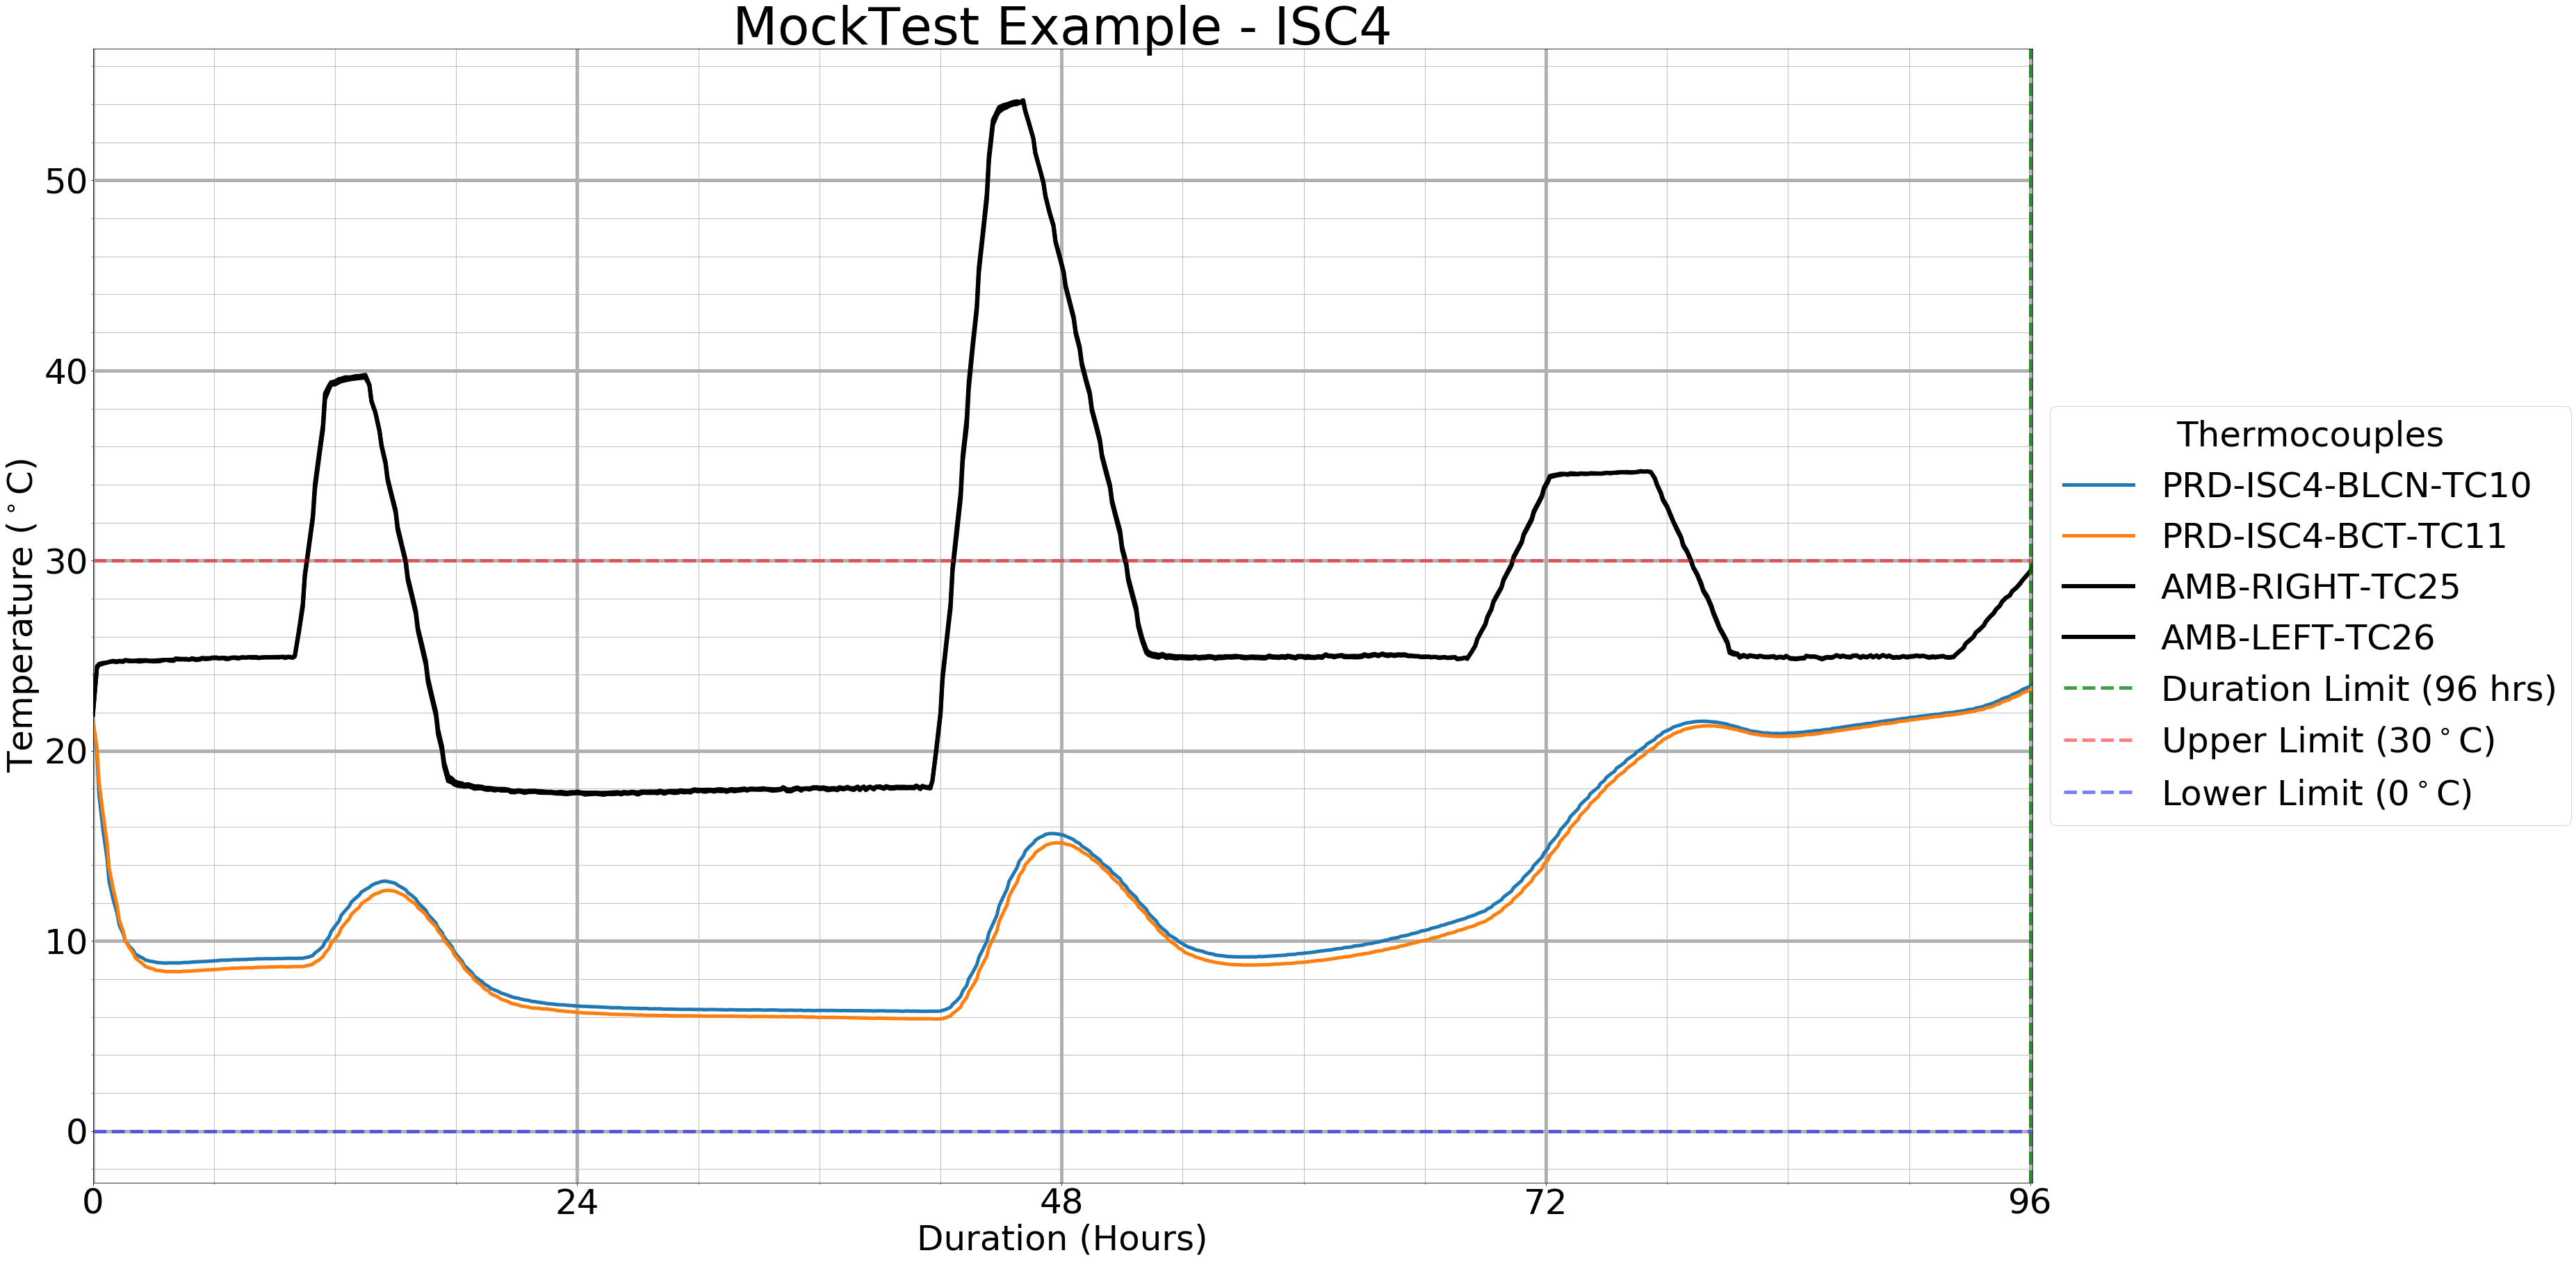

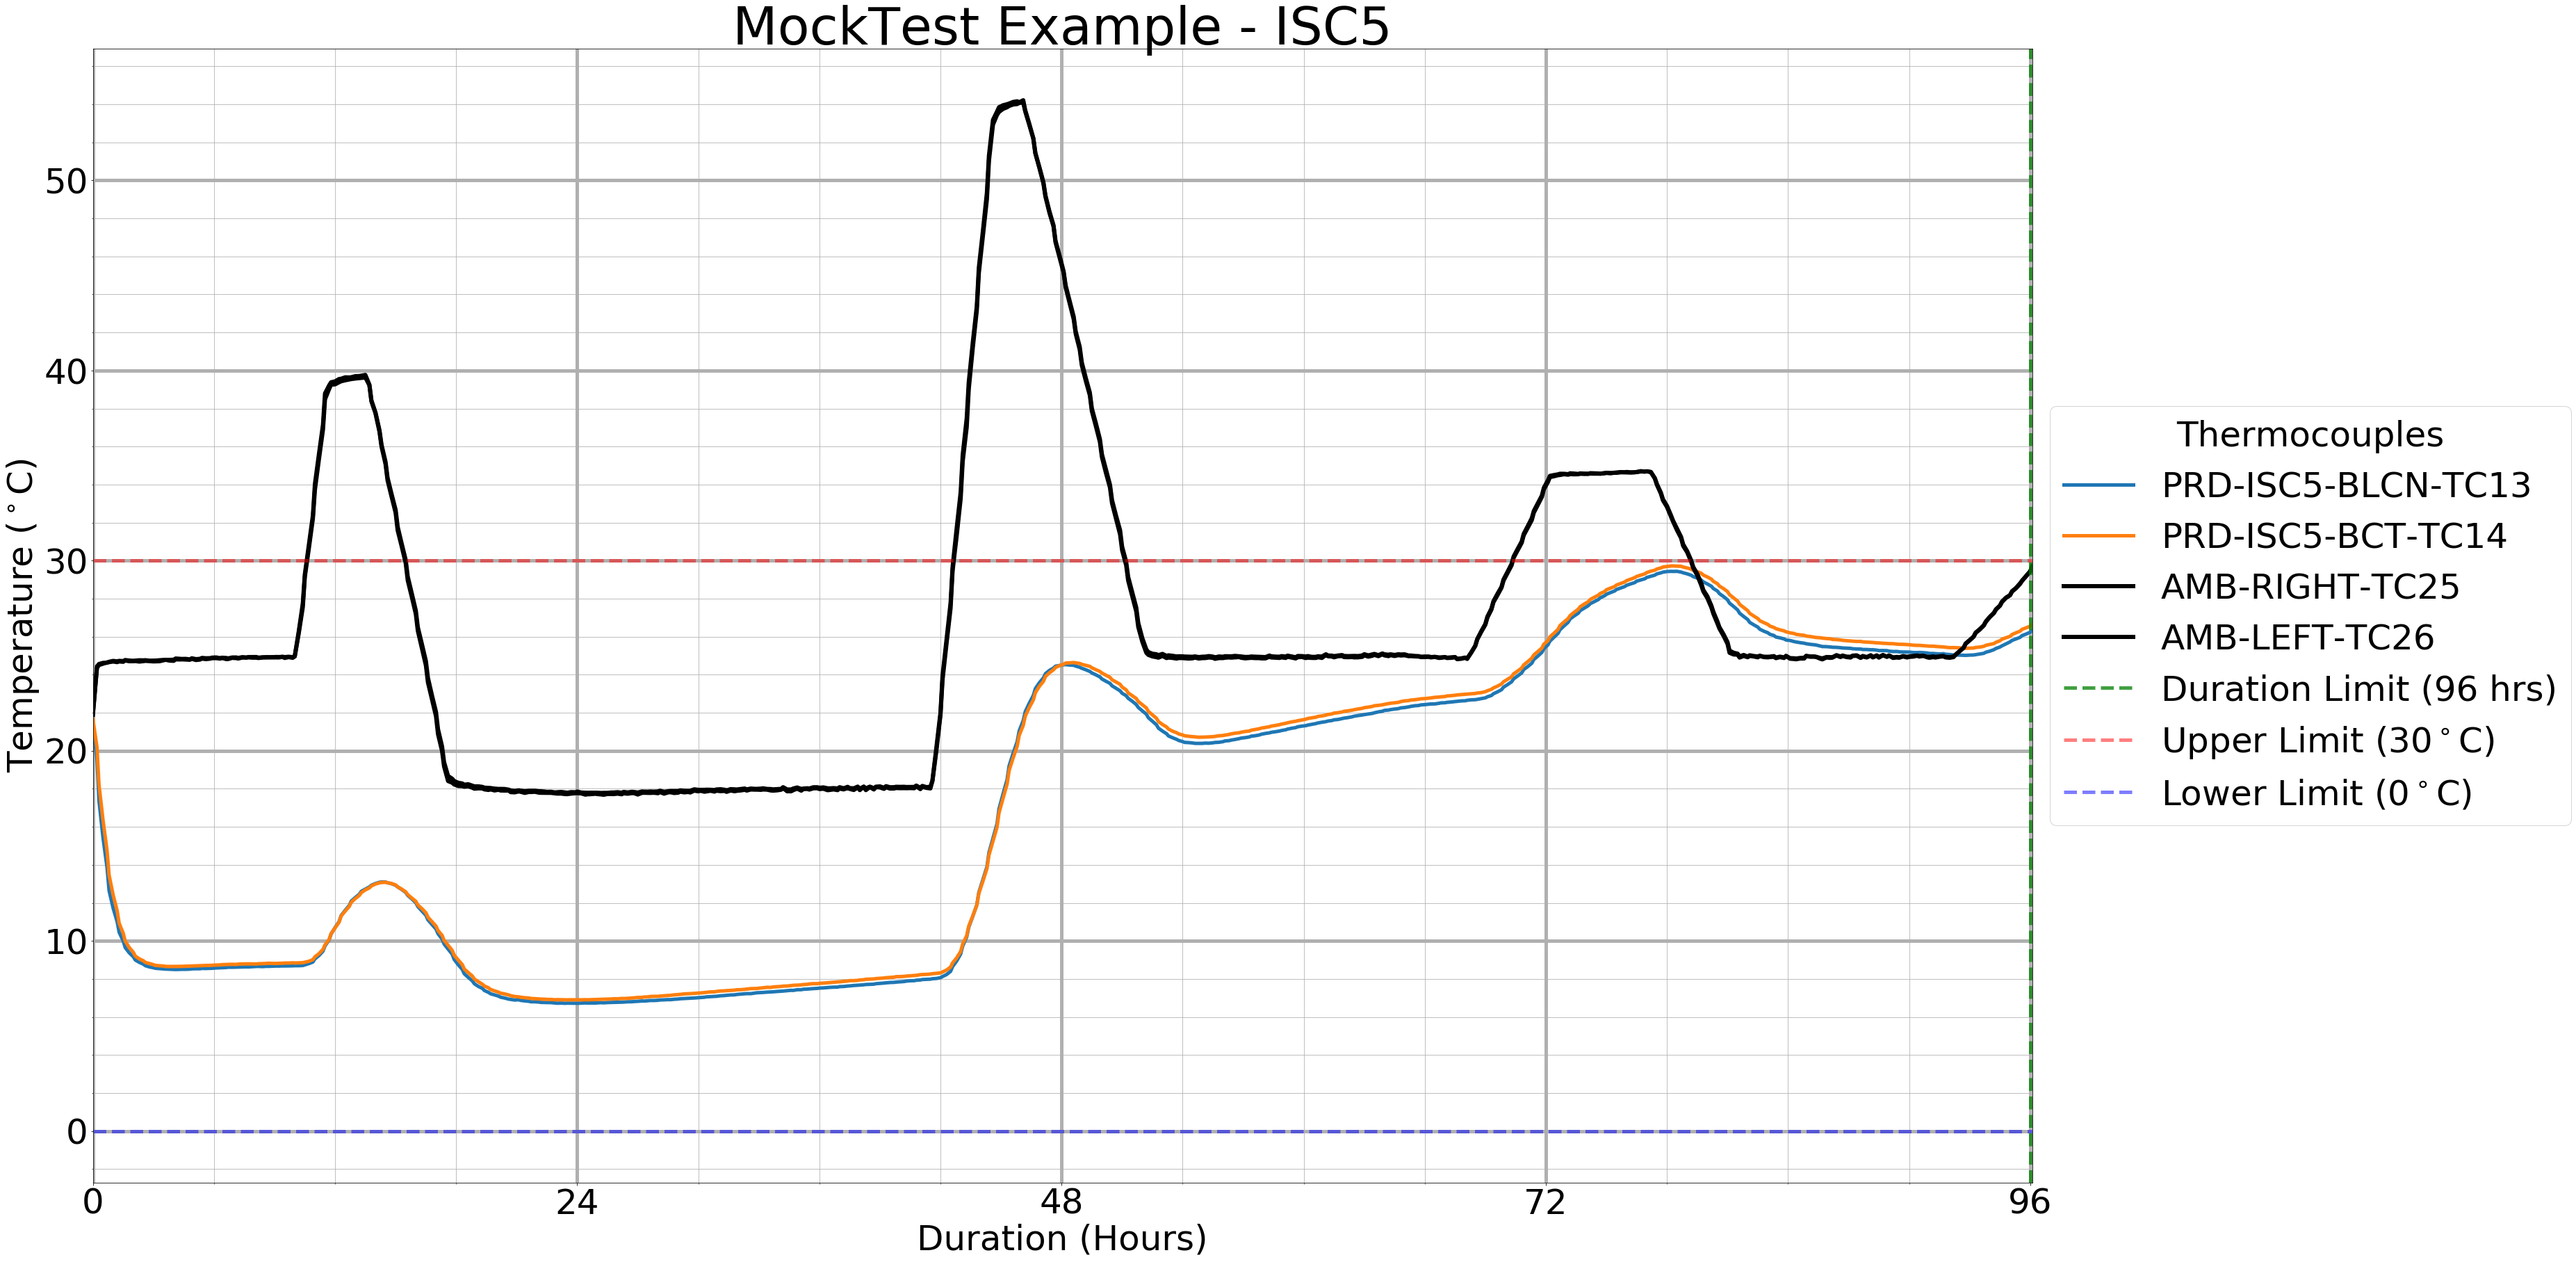

In [12]:
#Loop through each unique shipper ID and graph all probes
for x in range(max_shippers):
    fig1, ax1 = plt.subplots(figsize=(figsize))
    isc = f'ISC{x+num_index}'
    ISC = [tc_name for tc_name in tc_names if str(isc) in tc_name]
    for i in df_chart:
        if i in ISC:
            if i in prds:
                ax1.plot(df_chart[i], lw=linewidth)
            if air_probes==True:
                if i in airs:
                    ax1.plot(df_chart[i], lw=linewidth)
        if i in ambs:
            ax1.plot(df_chart[i], color='black', lw=1.2*linewidth)
        ax1.set_xticks(major_ticks, minor=False)
        ax1.set_xticks(minor_ticks, minor=True)
        ax1.grid(True, which='both')
        plt.minorticks_on()

    plt.title(f'{project_title} - {isc}', fontsize=fontsize*1.5)
    plt.xlabel('Duration (Hours)', fontsize=fontsize)
    plt.ylabel('Temperature ($^\circ$C)', fontsize=fontsize)
    plt.xlim(0,end_test)
    
    plt.axvline(x=duration, alpha=.75, linestyle='--', color='green', label=f"Duration Limit ({duration} hrs)", linewidth=linewidth)
    plt.axhline(y=upper_limit, alpha=.5, linestyle='--', color='red', label=f'Upper Limit ({upper_limit}$^\circ$C)', linewidth=linewidth)
    plt.axhline(y=lower_limit, alpha=.5, linestyle='--', color='blue', label=f'Lower Limit ({lower_limit}$^\circ$C)', linewidth=linewidth)
    
    plt.xticks(major_ticks)
    
    plt.tick_params(axis='both', which='major', labelsize=50)
    plt.grid(linewidth=linewidth)
    
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, .5), title='Thermocouples', ncol=1, fontsize=fontsize)
    leg.set_title('Thermocouples',prop={'size':fontsize})
    plt.savefig(f'figures/{project_title}/{project_title}-{isc}.png', bbox_inches='tight')
    plt.show()

# Temperature Analysis - All Probes
Ignores values outside of performance period

In [13]:
#calculate minimum and maximum temps rounded to required digits
min_temps = df_dur.min().round(round)
max_temps = df_dur.max().round(round)

#create temperature table dataframe
temp_table = pd.DataFrame({
    'Minimum Temp' : min_temps,
    'Maximum Temp' : max_temps})


#initialize lists for temperature checks
lower_check = []
upper_check = []
pass_check = []

#loop through dataframe and check each min/max temps against lower/upper limits
for i in temp_table['Minimum Temp']:
    if i < lower_limit:
        under_temp = i-lower_limit
        lower_check.append(f'Failed by {under_temp: .2f} deg')
    else:
        lower_check.append('Pass')
        
for i in temp_table['Maximum Temp']:
    if i > upper_limit:
        over_temp = i - upper_limit
        upper_check.append(f'Failed by {over_temp: .2f} deg')
    else:
        upper_check.append('Pass')

temp_table['Lower Limit Check'] = lower_check
temp_table['Upper Limit Check'] = upper_check

#determine overall pass/fail criteria
temp_table['Thermal Result'] = np.where(temp_table['Lower Limit Check'] != "Pass", "Failed Lower Limit",
                                   np.where(temp_table['Upper Limit Check'] != "Pass", 'Failed Upper Limit', 'Pass'))

#Re-arrange columns in table
temp_table = temp_table[['Minimum Temp', 'Lower Limit Check', 'Maximum Temp', 'Upper Limit Check', 'Thermal Result']]

#temp_table.index.name = "TC Name"
#temp_table.to_excel(writer, sheet_name='TempsbyProbes')
# writer.save()

#temp_table

# Temperature Analysis - By Shipper ID
Ignores values outside of performance period.

In [14]:
#Create summary table.  Shippers will be grouped by Shipper ID
temp_table_summary = temp_table[['Maximum Temp', 'Minimum Temp']]

#Categorize each TC name by Shipper ID and add to list
tc_groups = []
for name in temp_table_summary.index:
    for b in range(max_shippers):
        isc = f'ISC{b+num_index}'
        if isc in name:
            tc_groups.append(isc)

#Add shipper ID to table
temp_table_summary['Shipper'] = tc_groups

#Calculate min/max temperatures by temperature ID
temp_table_summary_min = temp_table_summary.groupby('Shipper')['Minimum Temp'].min()
temp_table_summary_max = temp_table_summary.groupby('Shipper')['Maximum Temp'].max()

#create summary table dataframe
summary_df = pd.DataFrame({
    'Minimum Temp' : temp_table_summary_min,
    'Maximum Temp' : temp_table_summary_max
})

#initialize lists for temperature checks
lower_check_group = []
upper_check_group = []
pass_check_group = []

#loop through dataframe and check each min/max temps against lower/upper limits
for i in summary_df['Minimum Temp']:
    if i < lower_limit:
        under_temp = lower_limit - i
        lower_check_group.append(f'Failed by {under_temp: .2f} deg')
    else:
        lower_check_group.append('Pass')
        
for i in summary_df['Maximum Temp']:
    if i > upper_limit:
        over_temp = i - upper_limit
        upper_check_group.append(f'Failed by {over_temp: .2f} deg')
    else:
        upper_check_group.append('Pass')

#determine pass/fail criteria by temperature and overall pass/fail      
summary_df['Lower Limit Check'] = lower_check_group
summary_df['Upper Limit Check'] = upper_check_group
summary_df['Thermal Result'] = np.where(summary_df['Lower Limit Check'] != "Pass", "Failed Lower Limit",
                                   np.where(summary_df['Upper Limit Check'] != "Pass", 'Failed Upper Limit', 'Pass'))

#Rearrange and show summary dataframe
summary_df = summary_df[['Minimum Temp', 'Lower Limit Check', 'Maximum Temp', 'Upper Limit Check', 'Thermal Result']]
#summary_df.to_excel(writer, sheet_name='TempsbyShipper')
#summary_df

# Duration Analysis - All Probes

In [15]:
# #Create dataframe from data to do duration analysis
df_dur_all = df_chart
df_dur_all = df_dur_all.drop(columns=ambs, axis=1)

#filter air probes if required
if air_probes == False:
    df_dur_all = df_dur_all.drop(columns=airs, axis=1)

#create duration dictionary to store analysis 
dict_df = {}

#determine index (elapsed hours) when the temperature is outside of allowable limits
#store index into dictionary
for col in df_dur_all:
    x = np.where((df_dur_all[col] < lower_limit) | (df_dur_all[col] > upper_limit))
    dict_df[col] = x[0]

#create list of index and tc name
dur_index = []
dur_names = []

#loop through dictionary to determine the time (index) at which probes failed
for key, value in dict_df.items():
    if len(value) > 0: #if the dictionary has data, length will be greater than 0
        dur_index.append(value[0]) #store the first value the probe failed
        dur_names.append(key)
    else: #if the dictionary key is empty, the probe never went out of spec
        dur_index.append(len(df_dur_all)) #store the maximum value of dataframe (index + 1)
        dur_names.append(key)
    
#subtract 1 from all index values to capture the LAST point when the probe was in spec
dur_index = [value - 1 for value in dur_index]

#create list of the durations by plugging the index into the duratino dataframe
dur_hours = df_dur_all.iloc[dur_index].index    

#convert lists to dataframe
dur_df_summary = pd.DataFrame({
    'TC Name' : dur_names,
    'Duration (Hours)': dur_hours
})

#check for pass/fail based on duration requirements
for i in dur_df_summary['Duration (Hours)']:
    if i >= duration:
        pass_check.append('Pass')
    else:
        short_time = duration - i
        pass_check.append(f'Failed by {short_time: .2f} hours')

#add column to dataframe
dur_df_summary['Duration Result'] = pass_check

#Rename index and show table
dur_df_summary = dur_df_summary.set_index("TC Name")
#dur_df_summary.to_excel(writer, sheet_name='DurationbyProbes')
#dur_df_summary

# Duration Analysis - By Shipper ID

In [16]:
#Create dataframe from data to do duration analysis
dur_df2 = dur_df_summary.reset_index()

#Add column of TC groups
dur_df2['Shipper'] = tc_groups

#Calculate the duration of the Shipper ID by grabbing the lowest duration value
dur_df2_min = dur_df2.groupby('Shipper')['Duration (Hours)'].min()

#Create summary dataframe
dur_summary = pd.DataFrame(dur_df2_min)

#initialize pass/check list
pass_check = []

#check for pass/fail based on duration requirements
for i in dur_summary['Duration (Hours)']:
    if i >= duration:
        pass_check.append('Pass')
    else:
        short_time = duration - i
        pass_check.append(f'Failed by {short_time: .2f} hours')

#add column to dataframe
dur_summary['Duration Result'] = pass_check
#dur_summary.to_excel(writer, sheet_name='DurationByShipper')

#display dataframe
#dur_summary

In [17]:
summary_all = pd.concat([summary_df, dur_summary], axis=1)
summary_all.to_excel(writer, sheet_name='SummaryByISC')
summary_all

,Minimum Temp,Lower Limit Check,Maximum Temp,Upper Limit Check,Thermal Result,Duration (Hours),Duration Result
Shipper,,,,,,,
ISC1,5.8,Pass,29.2,Pass,Pass,96.1,Pass
ISC2,8.7,Pass,37.5,Failed by 7.50 deg,Failed Upper Limit,45.3,Failed by 50.70 hours
ISC3,6.0,Pass,30.8,Failed by 0.80 deg,Failed Upper Limit,75.9,Failed by 20.10 hours
ISC4,5.9,Pass,23.4,Pass,Pass,96.1,Pass
ISC5,6.7,Pass,29.7,Pass,Pass,96.1,Pass


In [18]:
summary_isc = pd.concat([temp_table, dur_df_summary], axis=1)
temp_table.to_excel(writer, sheet_name='SummaryByProbe')
summary_isc

,Minimum Temp,Lower Limit Check,Maximum Temp,Upper Limit Check,Thermal Result,Duration (Hours),Duration Result
TC Name,,,,,,,
PRD-ISC1-BLCN-TC1,5.8,Pass,28.9,Pass,Pass,96.1,Pass
PRD-ISC1-BCT-TC2,6.6,Pass,29.2,Pass,Pass,96.1,Pass
PRD-ISC2-BLCN-TC4,8.8,Pass,37.5,Failed by 7.50 deg,Failed Upper Limit,45.3,Failed by 50.70 hours
PRD-ISC2-BCT-TC5,8.7,Pass,37.3,Failed by 7.30 deg,Failed Upper Limit,45.6,Failed by 50.40 hours
PRD-ISC3-BLCN-TC7,6.0,Pass,30.7,Failed by 0.70 deg,Failed Upper Limit,75.9,Failed by 20.10 hours
PRD-ISC3-BCT-TC8,6.0,Pass,30.8,Failed by 0.80 deg,Failed Upper Limit,75.9,Failed by 20.10 hours
PRD-ISC4-BLCN-TC10,6.3,Pass,23.4,Pass,Pass,96.1,Pass
PRD-ISC4-BCT-TC11,5.9,Pass,23.2,Pass,Pass,96.1,Pass
PRD-ISC5-BLCN-TC13,6.7,Pass,29.4,Pass,Pass,96.1,Pass


# Export Tabular Data to Excel

In [19]:
df_excel = df_formatted.set_index('Date Time')
df_excel = df_excel.round(decimals=round)

for x in range(max_shippers):
    isc = f'ISC{x+num_index}'
    ISC = [tc_name for tc_name in tc_names if str(isc) in tc_name]
    ISC.insert(0, 'Elapsed Time (Hours)')
    df_excel1 = df_excel[ISC]
    df_excel1.to_excel(writer, sheet_name=f'Duration - {isc}')
writer.save()

In [20]:
import datetime
tool_end = datetime.datetime.now()
tool_duration = (tool_end - tool_start).total_seconds()
print(f'Total Runtime of data processing: {tool_duration: .2f} seconds')

Total Runtime of data processing:  11.08 seconds
